# <center> IEDA3302 Project Group 2 </center>

<h4>
<table align = "right">
<tr>
<td> Name:</td>
<td> SID:</td>
</tr>
<tr>
<td> Tsang Chun Lung</td>
<td> 20692823</td>
</tr>
<tr>
<td> Yan Tsz Ching</td>
<td> 20703672</td>
</tr>
<tr>
<td> LEE Cheng han </td>
<td> 20742733</td>
</tr>
</table>
</h4>

<h4>


Background: Nowadays, E-commerce has been a key driver to the success of business intelligence. However, what price should the product to be set for is a concern. Data analysis according to the data collected from the internet would be helpful. For that , we are going to conduct data analysis on the data collected from one of the most famous E-commerce platform - HKTV Mall<br>

Objective: To find out the spending price according to different parameters including gender, age and product category <br>
From this project, the different stages of the code would be:
<ol>
<li>Introduction</li>
<li>Import of data and Data Preprocessing</li>
<li>Dimension Reduction</li>
<li>Regression</li>
<li>KNN Classifier</li>
<li>Support Vector Machine</li>
<li>Decision Tree</li>
<li>Conclusion of the analysis</li>
</ol>

</h4>

# Import of data and Data preprocessing <hr>
This part is done by Tsang Chun Lung.<br>
First we create an account from HKTV Mall Opensource Databank and take the transaction data from November, 2021 to November, 2022, each month's first day as the data. <br>
Then we also use the user data API to get the information of user and merge it together with the transaction.

In [1]:
import requests
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

### Data we going to use in csv

In [2]:
features = ["hktv_ad_id", "order_value", "primary_category_name_en"]

### Import csv, from 2021 November to 2022 November, each months 1st day

In [3]:
csv_1 = pd.read_csv('data/Public_Transaction_2021-11-01.csv', usecols=features)
csv_2 = pd.read_csv('data/Public_Transaction_2021-12-01.csv', usecols=features)
csv_3 = pd.read_csv('data/Public_Transaction_2022-01-01.csv', usecols=features)
csv_4 = pd.read_csv('data/Public_Transaction_2022-02-01.csv', usecols=features)
csv_5 = pd.read_csv('data/Public_Transaction_2022-03-01.csv', usecols=features)
csv_6 = pd.read_csv('data/Public_Transaction_2022-04-01.csv', usecols=features)
csv_7 = pd.read_csv('data/Public_Transaction_2022-05-01.csv', usecols=features)
csv_8 = pd.read_csv('data/Public_Transaction_2022-06-01.csv', usecols=features)
csv_9 = pd.read_csv('data/Public_Transaction_2022-07-01.csv', usecols=features)
csv_10 = pd.read_csv('data/Public_Transaction_2022-08-01.csv', usecols=features)
csv_11 = pd.read_csv('data/Public_Transaction_2022-09-01.csv', usecols=features)
csv_12 = pd.read_csv('data/Public_Transaction_2022-10-01.csv', usecols=features)
csv_13 = pd.read_csv('data/Public_Transaction_2022-11-01.csv', usecols=features)

### Joining all the csv into a large dataframe

In [4]:
df_1 = pd.concat([csv_1,csv_2,csv_3,csv_4,csv_5,csv_6,csv_7,csv_8,csv_9,csv_10,csv_11,csv_12,csv_13], ignore_index=True)

### Number of Data

In [5]:
df_1.shape[0]

3030730

### Read the user's data including gender and age range

In [6]:
f = open("data/sampleJSON.txt", encoding='utf-8').read()
feature = ["hktv_ad_id", "gender", "age_range"]
t = f.split("\n")
t.pop()
empty = []
for i in t:
    rows = json.loads(i)
    empty.append([rows["hktv_ad_id"], rows["gender"], rows["age_range"]])
df_2 = pd.DataFrame(empty, columns=feature)

### order value : From range (i.e. 5000-6000) to value (5000+6000 /2 = 5500)

In [7]:
#Make grouped data to numerical data

data = []
for i in range(len(df_1['order_value'])):
    num = df_1['order_value'][i].split(' - ')
    data.append((int(num[0])+int(num[1]))/2)

df_1["price"] = data

### same as order value, from age_range ot age

In [8]:
#Make grouped data to numerical data

data = []
for i in range(len(df_2['age_range'])):
    if df_2['age_range'][i] == None or df_2['age_range'][i] == "":
        data.append(np.nan)
        continue
    if df_2['age_range'][i].split('_')[1] == '55plus':
        data.append(60)
    elif df_2['age_range'][i].split('_')[1] == "12":
        data.append(10)
    else:
        num = df_2['age_range'][i].split('_')
        data.append((int(num[1])+int(num[2]))/2)

df_2['age'] = data

### Merging the transaction table and user data table, by the customer id (hktv_ad_id)

In [9]:
df = pd.merge(df_1, df_2, on="hktv_ad_id")
df.drop(labels=["order_value", "age_range"], axis=1, inplace=True)

In [10]:
#dealing with null and none data?
df['price'].fillna(value = df['price'].mean(), inplace = True)
df.dropna(inplace=True)

In [11]:
#Check for the missing value again
df.isna().sum()

hktv_ad_id                  0
primary_category_name_en    0
price                       0
gender                      0
age                         0
dtype: int64

In [12]:
#Rename the 'primary_category_name_en' to 'category'
df.rename(columns={'primary_category_name_en':'category', 'hktv_ad_id':'user'}, inplace=True)
#Reorder to let the target value to be the last column
df = df.reindex(columns=["user", "gender", "age", "category", "price"])

### Data visualization

In [13]:
import plotly.express as px

### From the graph below, we can see there are some data point that are extremely far away.

In [14]:
fig = px.scatter_3d(df, x='age', y='price', z='category',
                    color='gender', color_discrete_map={'M':'blue', 'F':'red'}, symbol='gender') #basic setting of the interactive 3d-scatter graph
fig.show()

### Thus we are going to detech outlier with Z-score > 3 and remove them

In [15]:
from scipy import stats

In [16]:
z = np.abs(stats.zscore(df['price']))
df = df.iloc[np.where(z > -3) and np.where(z < 3)]

### Correlation graph

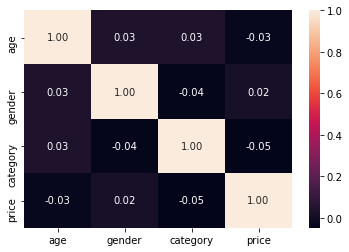

In [59]:
fig = plt.figure()
sns.heatmap(df[['age', 'gender', 'category', 'price']].corr(), annot=True, fmt=".2f")
plt.show()

### Then we need to encode the categorical data to numerical data so that we can train model later

In [18]:
from sklearn.preprocessing import LabelEncoder

In [19]:
l1 = LabelEncoder()
l2 = LabelEncoder()

l1.fit(df['gender'])
l2.fit(df['category'])
df['gender'] = l1.transform(df['gender'])
df['category'] = l2.transform(df['category'])

### Transform the float number to integer for model training.

In [20]:
df['age'] = df['age'].astype('int')
df['price'] = df['price'].astype('int')

### Total number of data left after data preprocessing

In [21]:
df.shape[0]

66358

### Overview of the data

In [22]:
df.head()

user  gender  age  category  price
8   LHXRgMIvLsJIsBZ9EcE6h8jLWkWboqseR1ftfkTPD/U=       0   22        11    324
17  W5UIVAX8xv2iZFRYSjDEOmX3wcpAEQvU+SW8p7hAFO4=       0   30        11    424
18  W5UIVAX8xv2iZFRYSjDEOmX3wcpAEQvU+SW8p7hAFO4=       0   30        11    424
19  W5UIVAX8xv2iZFRYSjDEOmX3wcpAEQvU+SW8p7hAFO4=       0   30        11     24
20  W5UIVAX8xv2iZFRYSjDEOmX3wcpAEQvU+SW8p7hAFO4=       0   30        11     24

# Dimention Reduction<hr>
This part is done by Tsang Chun Lung: <br>
After the data cleaning, integration and tranforming (filling missing value, detect outlier...), we will perform PCA to see if we can reduce some parameter(s).<br>

### Import library

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

### Standardize different parameter to do PCA

In [24]:
variables = ['category', 'gender', 'age']
x = df.loc[:, variables].values
y = df.loc[:,['price']].values
x = StandardScaler().fit_transform(x)
x = pd.DataFrame(x)

### Train the PCA model

In [25]:
pca = PCA()
x_pca = pca.fit_transform(x)
x_pca = pd.DataFrame(x_pca)
x_pca.head()

0         1         2
0 -1.037600  0.967883 -0.712092
1 -0.919198  0.325896 -0.264214
2 -0.919198  0.325896 -0.264214
3 -0.919198  0.325896 -0.264214
4 -0.919198  0.325896 -0.264214

### From Below, we can see that only two parameter cannot even capture 70% of the variance of the data, therefore we won't conduct any dimention reduction here.

In [26]:
explained_variance = pca.explained_variance_ratio_
explained_variance[:2].sum()

0.6900691924215301

In [27]:
x_pca['price']=y
x_pca.columns = ['category', 'gender', 'age', 'price']
x_pca.head()

category    gender       age  price
0 -1.037600  0.967883 -0.712092    324
1 -0.919198  0.325896 -0.264214    424
2 -0.919198  0.325896 -0.264214    424
3 -0.919198  0.325896 -0.264214     24
4 -0.919198  0.325896 -0.264214     24

# Regression<hr>
This part is done by Yan Tsz Ching:<br>
First, by using the processed data, we split the training dataset and test data set.<br>
After that, we would use the training set to training the multiple linear regression model.<br>
We will then used the model to predict the value by test dataset, and evaluate it with the real value of test dataset.

For 3 predictors (gender, age, category), the equation includes all the possible combinations of different order polynomials. This is known as Multi-dimensional Polynomial Regression.

1. Import all libraries needed

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

2. Split the dataframe into traing set and test set

In [29]:
X = df[['gender', 'age', 'category']]
Y = df['price']

df = df.sample(frac=1).reset_index(drop=True)# shuffle the data

# random_state is a pseudo-random number parameter that allows you to reproduce the same train test split each time you run the code. 
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, train_size = .8)

3. Build the Regression Model
   
    3.1. Multiple linear Regression

<h4>
Multiple linear regression: 
When two or more dependent (X) variables are required for a prediction the analysis is referred to as multiple linear regression.

The simple linear regression equation can be adapted to accommodate multiple dependent variables in the following way:
$$Y = a+b_{1}X_{1}+b_{2}X_{2}+b_{3}X_{3}+\cdots +b_{n}X_{n} $$
</h4>

In [30]:
mlr = LinearRegression()
mlr.fit(x_train, y_train)
y_pred_mlr = mlr.predict(x_test)

 Evaluation of regression model

In [31]:
mse_mlr = mean_squared_error(y_test, y_pred_mlr)
print(mse_mlr)

306141.74516635726


# KNN Tree<hr>
This part is done by Yan Tsz Ching:<br>
First, by using the processed data, we split the training dataset and test data set.<br>
After that, we would use the training set to training the 3 nearest neighbour classifier.<br>
We will then used the model to predict the value by test dataset, and evaluate it with the real value of test dataset.

In [32]:
from sklearn.neighbors import KNeighborsRegressor

In [33]:
knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(x_train, y_train)
train_preds = knn_model.predict(x_train)

In [34]:
mse_knn = mean_squared_error(y_train, train_preds)
print(mse_knn)

423978.4945392591


# Support Vector Machine <hr>
This part is done by Tsang Chun Lung and Yan Tsz Ching:<br>
First, by using the processed data, we split the training dataset and test data set.<br>
After that, we would use the training set to training the SVM Model.<br>
We have test different kernal including linear, polynomial, rbf, and sigmoid<br>
We will then used the model to predict the value by test dataset, and evaluate it with the real value of test dataset for each model.<br>
And choose the best among them.

In [35]:
from sklearn.svm import SVC

### Linear SVM : $𝐾(𝑥,𝑦)=𝑥𝑇𝑦 $

In [36]:
clf = SVC(kernel = "linear")
clf.fit(x_train[:1000], y_train[:1000])
y_pred_svm = clf.predict(x_test)

In [37]:
mse_svm1 = mean_squared_error(y_test, y_pred_svm)
print(mse_svm1)

422000.6875376733


### Polynomial SVM : $𝐾(𝑥,𝑦)=(𝑥𝑇𝑦+1)𝑑 $

In [38]:
clf = SVC(kernel = "poly")
clf.fit(x_train[:1000], y_train[:1000])
y_pred_svm = clf.predict(x_test)

In [39]:
mse_svm2 = mean_squared_error(y_test, y_pred_svm)
print(mse_svm2)

422000.6875376733


### rbf SVM : $K(x, y)=exp(-\gamma||x-y||2)$

In [40]:
clf = SVC(kernel = "rbf")
clf.fit(x_train[:1000], y_train[:1000])
y_pred_svm = clf.predict(x_test)

In [41]:
mse_svm3 = mean_squared_error(y_test, y_pred_svm)
print(mse_svm3)

422000.6875376733


### signmoid SVM : $𝐾(𝑥,𝑦)=𝑡𝑎𝑛ℎ(𝑎𝑥𝑇𝑦+𝑏)$

In [42]:
clf = SVC(kernel = "sigmoid")
clf.fit(x_train[:1000], y_train[:1000])
y_pred_svm = clf.predict(x_test)

In [43]:
mse_svm4 = mean_squared_error(y_test, y_pred_svm)
print(mse_svm4)

419938.0745177818


In [44]:
print(f"linear:{mse_svm1}, polynomial:{mse_svm2}, rbf:{mse_svm3}, signmoid:{mse_svm4}")

linear:422000.6875376733, polynomial:422000.6875376733, rbf:422000.6875376733, signmoid:419938.0745177818


# Decision Tree <hr>
This part is done by Lee Cheng han and Yan Tsz Ching:<br>
First, by using the processed data, we split the training dataset and test data set.<br>
After that, we would use the training set to training the Decision Model.<br>
We have test different DT Model including entropy and gini one<br>
We will then used the model to predict the value by test dataset, and evaluate it with the real value of test dataset for each model.<br>
And choose the best among them.

In [45]:
from sklearn.tree import DecisionTreeClassifier

In [46]:
# Create Decision Tree classifer object
clf1 = DecisionTreeClassifier(criterion='entropy',max_depth = 2)

# Train Decision Tree Classifer
clf1 = clf1.fit(x_train,y_train)

#Predict the response for test dataset
y_pred_dt = clf1.predict(x_test)

Evaluation of model

In [47]:
mse_clf1 = mean_squared_error(y_test, y_pred_dt)
print(mse_clf1)

422000.6875376733


In [48]:
# Create Decision Tree classifer object
clf2 = DecisionTreeClassifier(criterion='gini',max_depth = 2)

# Train Decision Tree Classifer
clf2 = clf2.fit(x_train,y_train)

#Predict the response for test dataset
y_pred_dt = clf2.predict(x_test)

In [49]:
mse_clf2 = mean_squared_error(y_test, y_pred_dt)
print(mse_clf2)

406418.06999698613


Visualization of decision tree

In [50]:
from sklearn import tree

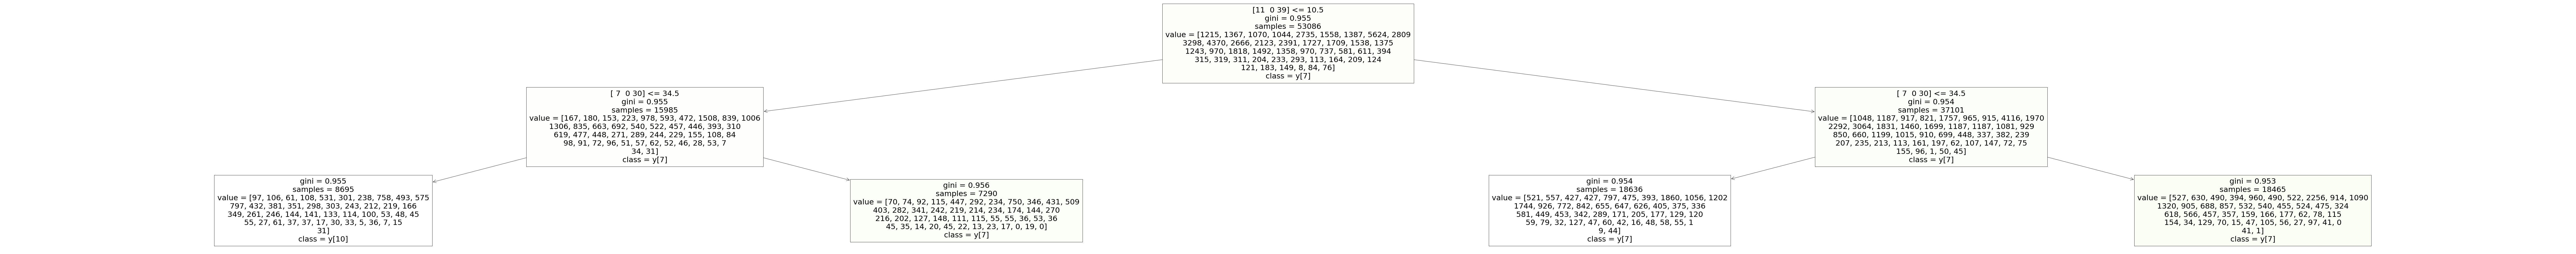

In [51]:
fig = plt.figure(figsize=(200,20))
variables = ['category', 'gender', 'age']
graph = tree.plot_tree(clf2, 
                   feature_names=df.loc[:, variables].values,  
                   class_names=True,
                   filled=True,
                   )

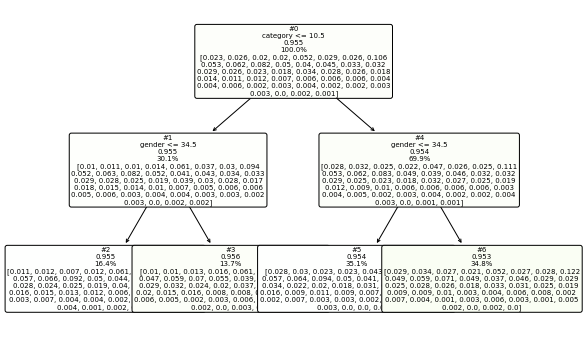

In [52]:
options = {
    "feature_names": ['age','gender','category'],
    "class_names": None,
    "label": None,
    "filled": True,
    "node_ids": True,
    "proportion": True,
    "rounded": True,
    "fontsize": 7,
}  # store options as dict for reuse

plt.figure(figsize=(9, 6))
tree.plot_tree(clf2, **options)  # ** unpacks dict as keyword arguments
plt.show()

# Conclusion <hr>
This part is done by Tsang Chun Lung:<br>
We will have the overview of all models and choose the best by their performance<br>
After that we will use the model to test the data<br>

### Let's have a overview on the evaluation of different models

In [53]:
# MSE
print("Mean Square Error of different Model:\n")
print(f"Mulitple Linear Regression:{mse_mlr}")
print(f"3 Nearest Neighbours:{mse_knn}")
print(f"Support Vector Machine (Linear):{mse_svm1}")
print(f"Support Vector Machine (Polynomial):{mse_svm2}")
print(f"Support Vector Machin (rbf):{mse_svm3}")
print(f"Support Vector Machin (sigmoid):{mse_svm4}")
print(f"Decision Tree (entropy):{mse_clf1}")
print(f"Decision Tree (gini):{mse_clf2}")

model = ["Mulitple Linear Regression", "3 Nearest Neighbours", "SVM (Linear)", "SVM (Poly)", "SVM (rbf)", "SVM (sigmoid)", "Deicision Tree (entropy)", "Decision Tree (gini)"]
mse = [mse_mlr, mse_knn, mse_svm1, mse_svm2, mse_svm3, mse_svm4, mse_clf1, mse_clf2]
min_index = np.argmin(mse)
print(f"The Model with minimum mean square error would be {model[min_index]} with mse {mse[min_index]}")

Mean Square Error of different Model:

Mulitple Linear Regression:306141.74516635726
3 Nearest Neighbours:423978.4945392591
Support Vector Machine (Linear):422000.6875376733
Support Vector Machine (Polynomial):422000.6875376733
Support Vector Machin (rbf):422000.6875376733
Support Vector Machin (sigmoid):419938.0745177818
Decision Tree (entropy):422000.6875376733
Decision Tree (gini):406418.06999698613
The Model with minimum mean square error would be Mulitple Linear Regression with mse 306141.74516635726


### Since it is difficult to plot out a graph with 4 parameter, so I will only plot out the graph comparsion between the actual value and predicted value

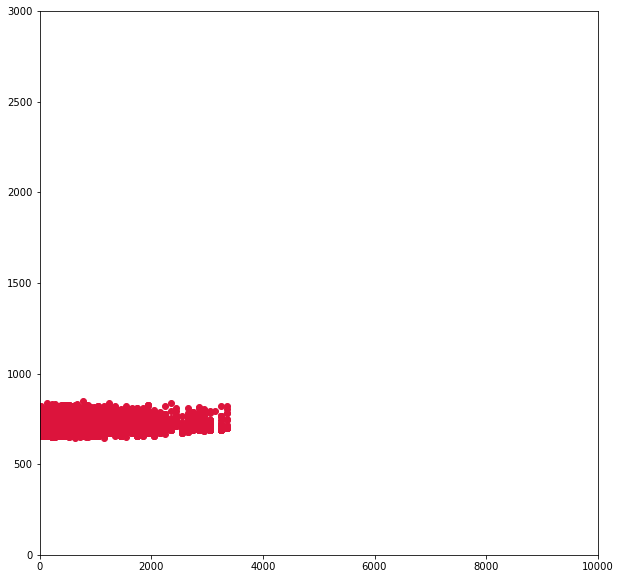

In [54]:
# Actual values and the predicted values
mlr_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred_mlr})

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred_mlr, c='crimson')
plt.xlim([0, 10000])
plt.ylim([0, 3000])
plt.show()

### By using this model, we can do prediction on the price based on user's gender, age and the product category

### For example: We want to predict a 22 years old male buying supermarket product

In [55]:
print("gender class: ", l1.classes_)
print("category class: ", l2.classes_)

gender class:  ['F' 'M']
category class:  ['13Landmarks' 'Electrical Appliances' 'Gadgets & Electronics'
 'Housewares' "Kids' Fashion" "Men's Fashion" 'Mother & Baby'
 'Personal Care & Health' 'Pets' 'Skincare & Makeup' 'Sports & Travel'
 'Supermarket' 'Toys & Books' "Women's Fashion"]


### From here, we can see the parameter we going to put into the Mutiple Linear Regression Model would be gender, age and category

In [56]:
x_test.head(1)

gender  age  category
102882       1   22        11

### Now let's see the amazing things ^^

In [57]:
target_value = mlr.predict(np.array([0, 22, 10]).reshape(1, -1))
print("A 22 years old male who buy supermarket product has a spending price of:",target_value[0])

A 22 years old male who buy supermarket product has a spending price of: 724.4589818340606


### Let's also compare the spending price between young woman and mature man on toys and books!

In [58]:
t1 =  mlr.predict(np.array([0, 20, 11]).reshape(1, -1))
t2 =  mlr.predict(np.array([1, 40, 11]).reshape(1, -1))

print("young woman: ", t1)
print("mature man: ", t2)

young woman:  [717.65082205]
mature man:  [709.17155613]


### Oh, They are actually similar! No discrimination on girls buying toys and books! <b>Gender equality!</b>